Stability of defection, optimisation of strategies and the limits of memory in the PD.
----------------------

## 2. Stability of defection

In [1]:
import opt_mo

import numpy as np
import sympy as sym
import itertools
import axelrod as axl
import matplotlib.pyplot as plt

//anaconda3/envs/opt-mo/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from fractions import Fraction

In [3]:
from axelrod.action import Action

C, D = Action.C, Action.D

In [4]:
import tqdm

In [5]:
import matplotlib.transforms as transforms
import matplotlib

In [6]:
import warnings; warnings.simplefilter('ignore')

In [7]:
import operator
import functools

In [8]:
sym.init_printing()

In [9]:
font = {"size": 10, "weight": "bold"}
matplotlib.rc("font", **font)

Analytical check
----------------

In [10]:
p_1, p_2, p_3, p_4 = sym.symbols("p_1, p_2, p_3, p_4")
q_1, q_2, q_3, q_4 = sym.symbols("q_1, q_2, q_3, q_4")
k_1, k_2, k_3, k_4 = sym.symbols("k_1, k_2, k_3, k_4")

p, q, k = (p_1, p_2, p_3, p_4), (q_1, q_2, q_3, q_4), (k_1, k_2, k_3, k_4)

In [11]:
def get_Q_N_derivative(player, opponent):
    x = np.array(player)
    
    Q = opt_mo.utility.quadratic_term_numerator(opponent)
    c = opt_mo.utility.linear_term_numerator(opponent)
        
    return np.dot(x, Q) + c

In [12]:
def get_Q_N(player, opponent):
    x = np.array(player)

    Q = opt_mo.utility.quadratic_term_numerator(opponent)
    c = opt_mo.utility.linear_term_numerator(opponent)
    a = opt_mo.utility.constant_term_numerator(opponent)

    return np.dot(x, Q.dot(x.T) * 1 / 2) + np.dot(c, x.T) + a

In [13]:
def get_Q_D(player, opponent):
    x = np.array(player)

    Q_bar = opt_mo.utility.quadratic_term_denominator(opponent)
    c_bar = opt_mo.utility.linear_term_denominator(opponent)
    a_bar = opt_mo.utility.constant_term_denominator(opponent)

    return np.dot(x, Q_bar.dot(x.T) * 1 / 2) + np.dot(c_bar, x.T) + a_bar

In [14]:
def get_Q_D_derivative(player, opponent):
    x = np.array(player)

    Q_bar = opt_mo.utility.quadratic_term_denominator(opponent)
    c_bar = opt_mo.utility.linear_term_denominator(opponent)
    a_bar = opt_mo.utility.constant_term_denominator(opponent)

    return np.dot(x, Q_bar) + c_bar

**Check quadratic derivative of**


$$\frac{1}{2}pQp^T + cp +a $$

In [15]:
expr = get_Q_N(p, q)

In [16]:
diff = [sym.diff(expr, i) for i in p]

In [17]:
derivatives = get_Q_N_derivative(p, q)

In [17]:
for i in range(4):
    assert (diff[i] - derivatives[i]).simplify() == 0

**Check derivative of utility**

In [18]:
def get_written_derivative_of_utility(player, opponents):
    sums = 0
    for opponent in opponents:
        numerator = (get_Q_N_derivative(player, opponent) * get_Q_D(player, opponent) -
                      get_Q_D_derivative(player, opponent) * get_Q_N(player, opponent))
        
        denominator = get_Q_D(player, opponent) ** 2
        
        sums += numerator / denominator
    return (sums) * (1 / len(opponents))

In [19]:
for seed in range(100):
    num_players = 5
    np.random.seed(seed)
    opponents = [[np.random.random() for _ in range(4)] for _ in range(num_players)]
    
    np.random.seed(seed + 1000)
    player = [np.random.random() for _ in range(4)]
    
    written_derivative = get_written_derivative_of_utility(player, opponents)
    
    utility = opt_mo.tournament_utility(p, opponents)
    utility_derivative = [sym.diff(utility, i) for i in p]
    utility_derivative = [expr.subs({p_1: player[0], p_2: player[1], p_3: player[2], p_4: player[3]}) for expr
                          in utility_derivative]
    
    differences = written_derivative - utility_derivative
    for difference in differences:
        assert np.isclose(round(difference, 10), 0)

In [21]:
opponents = [q, k]

In [22]:
utility = opt_mo.tournament_utility(p, opponents)
derivative_of_utility = [sym.diff(utility, i) for i in p]

In [23]:
written_derivative = get_written_derivative_of_utility(p, opponents)

In [65]:
for i in tqdm.tqdm(range(4)):
    assert (written_derivative[i] - derivative_of_utility[i]).simplify() == 0


100%|██████████| 4/4 [02:34<00:00, 24.63s/it]

**Stability of defection**

**Check condition for defection stability**

In [24]:
opponents = [q, k]

In [25]:
utility = opt_mo.tournament_utility(p, opponents)

In [26]:
diff_utility = [sym.diff(utility, i) for i in p]

In [27]:
diff_utility_at_zero = [expr.subs({p_1: 0, p_2: 0, p_3: 0, p_4: 0}).expand() for expr in diff_utility]

In [28]:
def get_derivate_for_p_zeros(opponents):
    sums = 0
    for opponent in opponents:
        lhs = opt_mo.utility.linear_term_numerator(opponent) * opt_mo.utility.constant_term_denominator(opponent)
        rhs = opt_mo.utility.linear_term_denominator(opponent) * opt_mo.utility.constant_term_numerator(opponent)
        
        denominator = opt_mo.utility.constant_term_denominator(opponent) ** 2
        
        sums +=  (lhs - rhs) / denominator

    return (sums) * (1 / len(opponents))

In [29]:
expression = get_derivate_for_p_zeros(opponents)

In [27]:
for i in tqdm.tqdm(range(4)):
    assert (diff_utility_at_zero[i] - expression[i]).simplify() == 0

100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


In [78]:
def stackplot(plot, eco, title=None,logscale=True, ax=None):

    populations = eco.population_sizes
    if ax is None:
        _, ax = plt.subplots()
    else:
        ax = ax
    figure = ax.get_figure()
    turns = range(len(populations))
    pops = [
        [populations[iturn][ir] for iturn in turns]
        for ir in plot.result_set.ranking
    ]
    ax.stackplot(turns, *pops)

    ax.yaxis.tick_left()
    ax.yaxis.set_label_position("right")
    ax.yaxis.labelpad = 25.0

    ax.set_ylim([0.0, 1.0])
    #ax.set_xlim([0.0, 10 ** 3])
    ax.set_ylabel("Relative population size", fontweight='bold')
    ax.set_xlabel("Turn", fontweight='bold')

    trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
    ticks = []
    for i, n in enumerate(plot.result_set.ranked_names):
        x = -0.01
        y = (i + 0.5) * 1 / plot.result_set.num_players
        if n != 'Defector':
            opponent_strings = (n.split(':')[1].replace('[', '').replace(']', '')).split(",")
            opponent = [Fraction(float(op)).limit_denominator() for op in opponent_strings]
            label = '$q_{%s}$'% i
#             for p in range(3):
#                 label += r'\frac{' + str(opponent[p].numerator) + '}{' + str(opponent[p].denominator) + '},'
#             label += r'\frac{' + str(opponent[3].numerator) + '}{' + str(opponent[3].denominator) + '})$'
#             print(label)
            n = label
        ax.annotate(
            n,
            xy=(x, y),
            xycoords=trans,
            clip_on=False,
            va="center",
            ha="right",
            fontsize=10,
        )
        ticks.append(y)
    ax.set_yticks(ticks)
    ax.tick_params(direction="out")
    ax.set_yticklabels([])
    if title is not None:
        ax.set_title(title, fontweight="bold")     
    if logscale:
        ax.set_xscale("log")
    for tick in ax.yaxis.get_majorticklabels():  # example for xaxis
        tick.set_fontsize(20) 
        
    plt.tight_layout()
    ax.set_xlim(0, 10 **2)
    return figure

In [60]:
for seed in range(2, 10):
    np.random.seed(seed)
    opponents = [[np.round(np.random.random(), 5) for _ in range(4)] for _ in range(3)]

    derivative = get_derivate_for_p_zeros(opponents)
    
    if all([el < 0 for el in derivative]):
        print('Found at: %s' % seed)
        break

Found at: 5


In [61]:
defection_stable_opponents_set = [axl.MemoryOnePlayer(ps, initial=D) for ps in opponents] + [axl.Defector()]

In [62]:
tournament = axl.Tournament(defection_stable_opponents_set)
results = tournament.play(progress_bar=False)
eco = axl.Ecosystem(results)
eco.reproduce(500)

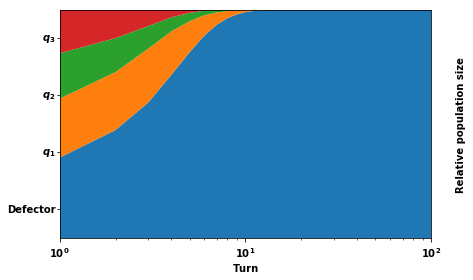

In [63]:
plot = axl.Plot(results)
p = stackplot(plot, eco)

In [33]:
p.savefig('../img/population_defection_takes_over.pdf', bbox_inches='tight')

In [64]:
for seed in range(5000):
    np.random.seed(4)
    opponents = [[round(np.random.random(), 5) for _ in range(4)] for _ in range(3)]
    
    np.random.seed(seed)
    other_opponent =[[np.random.random() for _ in range(4)]]
    
    derivative = get_derivate_for_p_zeros(opponents + other_opponent)
    if all([el < 0 for el in derivative]):
        print('Found at: %s' % seed)
        break

In [65]:
defection_unstable_opponents_set = [axl.MemoryOnePlayer(ps, initial=C) for ps in opponents]
defection_unstable_opponents_set += [axl.Defector()]

In [66]:
tournament = axl.Tournament(defection_unstable_opponents_set)
results_two = tournament.play(progress_bar=False)
eco_two = axl.Ecosystem(results_two)
eco_two.reproduce(50000)

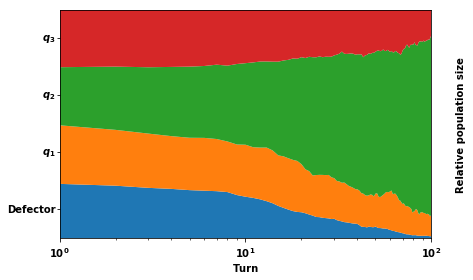

In [67]:
plot = axl.Plot(results_two)
p = stackplot(plot, eco_two)

In [ ]:
p.savefig('../img/population_defection_fails.pdf', bbox_inches='tight')

**Both in single plot**

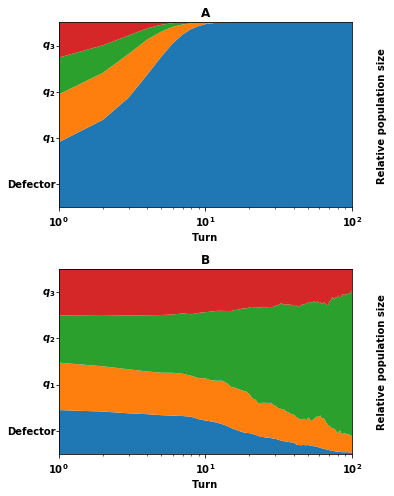

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 7))
plot = axl.Plot(results)
p = stackplot(plot, eco, ax=axes[0], title='A')

plot = axl.Plot(results_two)
p = stackplot(plot, eco_two, ax=axes[1], title='B')

In [81]:
p.savefig('../img/stability_of_defection_plots.pdf', bbox_inches='tight')